## Outils pour la manipulation d'images et librairies.


In [23]:
import PIL as pil
from PIL import Image, ImageTk
import numpy as np
import scipy as sp
import tkinter as tk
from tkinter import filedialog, simpledialog
import os
import random
from math import log10, sqrt

def load(filename):
    toLoad= Image.open(filename)
    return np.asarray(toLoad)


def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def dct2(a):
    return sp.fft.dct( sp.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return sp.fft.idct( sp.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

nomImg=""


## Normalisation de l'image (YCbCr et padding)

QUESTION 1 : 
Donner le code qui transforme une image RGB en une image YCbCr. Vous pourrez produire une matrice pour chaque composante, pour pouvoir plus facilement les manipuler ind ́ependamment. Vous pouvez stocker les donn ́ees YCbCr comme des entiers ou des flottants, mais vous expliquerez votre choix.

In [46]:
def YCbCr(mat):
    matYCbCr=np.empty((mat.shape[0],mat.shape[1],3),dtype=np.float64)

    for i in range(matYCbCr.shape[0]):
        for j in range(matYCbCr.shape[1]):
            matYCbCr[i,j,0] = 0.299 * mat[i,j,0] + 0.587 * mat[i,j,1] + 0.114 * mat[i,j,2]
            
            matYCbCr[i,j,1] = - 0.1687 * mat[i,j,0] - 0.3313 * mat[i,j,1] + 0.5 * mat[i,j,2] + 128

            matYCbCr[i,j,2] = 0.5 * mat[i,j,0] - 0.4187 * mat[i,j,1] - 0.0813 * mat[i,j,2] + 128
            
    return matYCbCr

QUESTION 2 : Donner le code qui transforme une image YCbCr en une image RGB. Attention, les valeurs des canaux RGB doivent ˆetre un entier dans [0, 255] qui pourra ˆetre cod ́e sur un octet. Appliquer successivement la transformation RGB vers YCbCr puis YCbCr vers RGB et v ́erifier que vous obtenez l’image de d ́epart. Vous consulterez la documentation des fonctions de numpy clip, uint8 et mask qui pourraient vous ˆetre utiles.

In [48]:
def RGB(mat):
    matRGB=np.empty([mat.shape[0],mat.shape[1],3],dtype=np.uint8)

    for i in range(matRGB.shape[0]):
        for j in range(matRGB.shape[1]): 
            
            y = mat[i,j,0]
            cb = mat[i,j,1]
            cr = mat[i,j,2]
            
            r = y + 1.402 * (cr - 128) 
            g = y - 0.34414 * (cb - 128) - 0.71414 * (cr - 128)
            b = y + 1.772 * (cb - 128)
            
            matRGB[i,j,0] = int(r)
            
            matRGB[i,j,1] = int(g)
            
            matRGB[i,j,2] = int(b)
             
    return matRGB

In [53]:
test = load("test.png")
compresse = YCbCr(test)
nouveau = RGB(compresse)
print(psnr(test, nouveau))

63.79010503046213


QUESTION 3 : 
Pour pouvoir traiter une image, nous avons besoin que ses dimensions soient des multiples de 8. Pour le garantir, il faut faire du remplissage (padding), c’est `a dire qu’on va ajouter des lignes et des colonnes de pixel noirs en bas et `a droite de l’image. Si on a une image de dimension 15×21, on obtiendra une image de dimension 16 × 24 avec une ligne suppl ́ementaire et trois colonnes suppl ́ementaires.

In [ ]:
def padding(mat):
    mat=load(nomImg)
    while mat.shape[0] %8 != 0:
        mat[0].append(0,0,0)
    while mat.shape[1] %8 != 0:
        mat[1].append(0,0,0)

def retire_padding(mat):
    mat=load(nomImg)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if mat[i,j]==(0,0,0):
                mat.remove(mat[i,j])

QUESTION 4 : Impl ́ementer la fonction qui sous- ́echantillonne une matrice et renvoie une matrice deux fois plus petite.

In [ ]:
def petite_mat(mat):
    mat=load(nomImg)
    mat_reduite=np.empty([mat.shape[0]//2, mat.shape[1],3],dtype=np.uint8)
    for i in range(mat_reduite.shape[0]):
        for j in range(mat_reduite.shape[1]):
            mat_reduite[i,j]=((mat[i]+mat[i+1])//2 , mat[j])


QUESTION 5 : Impl ́ementer la fonction qui multiplie par deux la deuxi`eme dimension d’une matrice. Tester `a la suite le sous- ́echantillonnage et cette fonction, vous devez retrouver une image presque identique `a celle de d ́epart.

In [ ]:
mat * 2

## Découpage en blocs et compression

QUESTION 6 : Soit une matrice dont les deux dimensions sont divisibles par 8. Donner une fonction qui d ́ecoupe cette matrice en blocs 8 × 8 et les stocke dans une liste. L’ordre des blocs correspond `a l’ordre de lecture d’une image.

QUESTION 7 : Donner une fonction qui applique la transform ́ee `a chaque bloc d’une liste.

QUESTION 8 : Impl ́ementez le filtrage des coefficients des blocs selon un seuil donn ́e en argument.

QUESTION 9 : Donner une fonction qui est capable, `a partir d’une image RGB, de cr ́eer les listes de blocs compress ́es dans les 3 modes.

## Écriture dans un fichier

QUESTION  10 : Pour commencer, vous  ́ecrirez quatres lignes contenant les informations de votre image. La premi`ere ligne contiendra le type du fichier : “SJPG”. La deuxi`eme ligne contiendra les dimensions de l’image dans l’ordre hauteur puis largeur, s ́epar ́ees par un espace, par exemple “200 300”. La troisi`eme ligne contiendra le mode de compression, par exemple “mode 1”. La quatri`eme ligne contiendra “RLE” si vous utilisez un run length encoding, ou “NORLE” sinon.

QUESTION 11 : Vous  ́ecrirez ensuite le contenu des blocs, d’abord ceux de Y, puis ceux de Cb puis ceux de Cr. Chaque bloc est  ́ecrit sur une ligne, les valeurs  ́etant des entiers s ́epar ́es par de espaces.

QUESTION 12 : Ajouter une option `a votre fonction d’ ́ecriture pour qu’elle puisse  ́ecrire les blocs en appliquant le codage RLE.

## Décompression

QUESTION 13 : E ́crire une fonction de d ́ecompression qui prend une liste de blocs pour chaque canal Y,Cb,Cr contenant les coefficients de la DCT et calcule une matrice repr ́esentant l’image en RGB.

QUESTION 14 : E ́crire une fonction qui lit un fichier SJPG et qui cr ́e ́e les listes de blocs d ́ecrites par le fichier.

## Optimisations

QUESTION 15 :  Impl ́ementer une fonction qui r ́ealise la compression en mode 3. La d ́ecompression ne change pas.

QUESTION 16 : Impl ́ementer la compression et la d ́ecompression par le mode 4. L’ ́ecriture dans un fichier ne change pas.

QUESTION 17 : E ́crire et lire les coefficients dans le fichier en suivant l’ordre en zig-zag.

## Tests 

In [49]:
test = load("test.png")
Image.fromarray(test,'RGB').show()

In [50]:
imgycbcr= YCbCr(test)
Image.fromarray(imgycbcr, 'YCbCr').show()

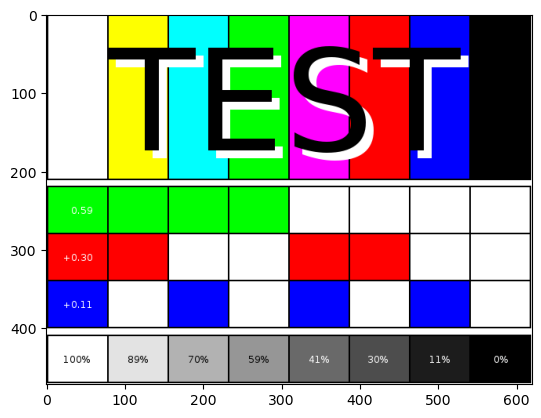

In [52]:
import matplotlib.pyplot as plt
imgRGB= RGB(imgycbcr)
plt.imshow(imgRGB)
plt.show()